### Preprocessing Data

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
from itertools import islice
import numpy as np

filename_infrastructure = 'data_unwrangled/20221017_Centerline-clipped.shp'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
filename_boundaries = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'

In [2]:
infrastructure = gpd.read_file(filename_infrastructure)

In [3]:
filter_ = gpd.read_file(filename_boundaries)
filter_ = filter_[filter_['boro_name'] == 'Manhattan']

In [4]:
collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])

# Restrict to collisions involving bicycles
markers = ['bike', 'bicyc', 'e - b', 'e-bik', 'e-unicycle', 'bk']
mask = collisions['VEHICLE TYPE CODE 1'].str.contains('bike') # placeholder
for i in [1,2,3,4,5]:
    for marker in markers:
        mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains(marker, case=False)

collisions = collisions.loc[mask]

# Restrict to filter
collisions = collisions[collisions.LONGITUDE != 0] # remove 0,0 coordinates
collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

collisions_restricted = collisions.sjoin(filter_)
if 'index_right' in collisions_restricted.columns:
    collisions_restricted.drop(columns=['index_right'], inplace=True)

collisions_restricted['collision_ID'] = collisions_restricted.index # add ID column

# Connect collisions to infrastructure
collisions_connected = collisions_restricted.sjoin_nearest(infrastructure, max_distance=0.0001, how='inner')
if 'index_right' in collisions_connected.columns:
    collisions_connected.drop(columns=['index_right'], inplace=True)
if 'index_left' in collisions_connected.columns:
    collisions_connected.drop(columns=['index_left'], inplace=True)

collisions_connected.drop_duplicates(subset=['collision_ID'], keep='first', inplace=True)

/var/folders/9j/ht0lbv2j6wg_lct_dp038f1m0000gn/T/ipykernel_2018/4118191707.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])
/Users/sdb425/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/Users/sdb425/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:2202: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROI

In [5]:
collisions_connected['CRASH DATE'] = pd.to_datetime(collisions_connected['CRASH DATE'])
collisions_connected.groupby([collisions_connected['CRASH DATE'].dt.year]).count()
## Let's start in 2016 since previous years of citibike have far fewer rides

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,rw_type,shape_leng_right,snow_pri,st_label,st_name,st_width,status,to_lvl_co,trafdir,Shape_Le_1
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,800,800,795,795,800,800,800,792,792,3,...,800,800,793,800,800,800,800,800,800,800
2013,1654,1654,1652,1652,1654,1654,1654,1644,1644,8,...,1654,1654,1635,1654,1654,1654,1654,1654,1654,1654
2014,1687,1687,1686,1686,1687,1687,1687,1680,1680,6,...,1687,1687,1671,1687,1687,1687,1687,1687,1687,1687
2015,1733,1733,1726,1726,1733,1733,1733,1716,1716,13,...,1733,1733,1715,1733,1733,1733,1733,1733,1733,1733
2016,1900,1900,1480,1480,1900,1900,1900,1471,1146,428,...,1900,1900,1889,1900,1900,1900,1900,1900,1900,1900
2017,2005,2005,1420,1420,2005,2005,2005,1504,972,501,...,2005,2005,1988,2005,2005,2005,2005,2005,2005,2005
2018,2002,2002,1478,1478,2002,2002,2002,1551,1061,451,...,2002,2002,1981,2002,2002,2002,2002,2002,2002,2002
2019,2085,2085,1503,1503,2085,2085,2085,1609,1064,476,...,2085,2085,2070,2085,2085,2085,2085,2085,2085,2085
2020,1630,1630,1133,1133,1630,1630,1630,1303,839,327,...,1630,1630,1615,1630,1630,1630,1630,1630,1630,1630


In [6]:
start_date = pd.Timestamp('2016-01-01')
collisions_recent = collisions_connected.loc[collisions_connected['CRASH DATE'] >= start_date]

In [7]:
year = '2016'
month = '01'
filename_citibike = f'/Users/sdb425/Dropbox/Bike Data/Data/CitiBike/NYC/{year}{month}-citibike-tripdata.csv'
citibike_yearmonth = pd.read_csv(filename_citibike)

In [8]:
citibike_yearmonth = gpd.GeoDataFrame(citibike_yearmonth)
citibike_yearmonth['start_geom'] = gpd.points_from_xy(citibike_yearmonth['start station longitude'], citibike_yearmonth['start station latitude'])
citibike_yearmonth['end_geom'] = gpd.points_from_xy(citibike_yearmonth['end station longitude'], citibike_yearmonth['end station latitude'])

In [14]:
import momepy

G = momepy.gdf_to_nx(infrastructure, approach="primal")

/Users/sdb425/Library/Python/3.9/lib/python/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [15]:
len(G.nodes), len(G.edges)

(7749, 13134)

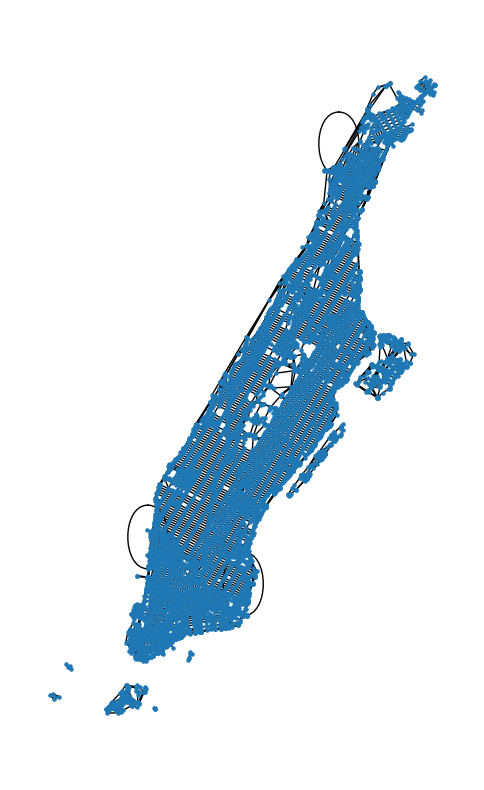

In [16]:
import matplotlib.pyplot as plt

positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 1, figsize=(6, 10), sharex=True, sharey=True)
# centerline_clip.plot(color="k", ax=ax[0])
# for i, facet in enumerate(ax):
#     facet.set_title(("Centerline Clipped", "Graph")[i])
#     facet.axis("off")
nx.draw(G, positions, ax=ax, node_size=5)

In [19]:
import numpy.linalg as linalg

Lpinv = linalg.pinv(nx.laplacian_matrix(G, nodelist=G.nodes).todense())

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [20]:
vector = np.zeros(len(G.nodes))
# vector[G.nodes.index(19)] = 1
# vector[G.nodes.index(93)] = -1

In [21]:
resistance = vector.T.dot(Lpinv).dot(vector)
(Lpinv@ vector).round(3)

array([[0., 0., 0., ..., 0., 0., 0.]])